# Detecting strain variation by looking at high-degree nodes within reads

To generate output:

```
load-graph.py akker-reads.ng akker-reads.abundtrim.gz -M 1e9 -k 31 --no-build-tagset
./measure-reads.py akker-reads.ng ../akker-reads.abundtrim.gz

load-graph.py shew-reads.ng shewanella.abundtrim.gz -M 1e9 -k 31 --no-build-tagset
./measure-reads.py shew-reads.ng ../shewanella.abundtrim.gz 
```

(see [cats-in-practice-pipeline Makefile](https://github.com/spacegraphcats/cats-in-practice-pipeline/blob/master/Makefile) for origin of reads files w/trimming parameters, etc.)

In [1]:
ls

akker-reads.ng.hdn.csv  hdn.ipynb               shew-reads.ng.hdn.csv
akker-reads.ng.info     hdn.sh*                 shew-reads.ng.info
data/                   measure-reads.py*


In [2]:
!head akker-reads.hdn.csv


head: akker-reads.hdn.csv: No such file or directory


In [3]:
import csv
import numpy

def read_hdn(filename):
    x = []
    with open(filename) as fp:
        r = csv.DictReader(fp)
        for row in r:
            x.append((int(row['hdn_count']), int(row['n_reads'])))
    return numpy.array(x)

In [4]:
akker = read_hdn('akker-reads.ng.hdn.csv')
shew = read_hdn('shew-reads.ng.hdn.csv')

In [5]:
%matplotlib inline
from matplotlib import pyplot

(0.0, 10, 0.0, 900000.0)

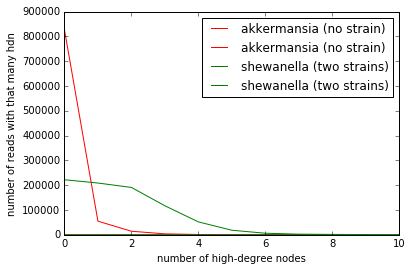

In [6]:
pyplot.plot(akker, 'r-', label='akkermansia (no strain)')
pyplot.plot(shew, 'g-', label='shewanella (two strains)')
pyplot.legend(loc='upper right')
pyplot.xlabel('number of high-degree nodes')
pyplot.ylabel('number of reads with that many hdn')
pyplot.axis(xmax=10)

# Looking at the podar data set 

In [7]:
# load in the CSVs
import glob

hdn_csvs = {}
for n in range(0, 64):
    filename = 'data/{}.fa.ng.hdn.csv'.format(n)
    hdn_csvs[n] = read_hdn(filename)


In [8]:
# load in the minhash signatures
sigs = {}
names = {}

from sourmash_lib import signature
KSIZE=21
for n in range(0, 64):
    filename = 'data/{}.fa.sig'.format(n)
    sig = signature.load_one_signature(filename, select_ksize=KSIZE)
    sigs[n] = sig
    names[n] = sig.name()

In [9]:
# look at the ratios of 0-hdn to 1-hdn - lower ratio => more strain variation?

ratios = []
for k,v in hdn_csvs.items():
    r = v[0][1] / v[1][1]
    ratios.append(r)

(array([  9.,   6.,  14.,  11.,   7.,   7.,   5.,   1.,   2.,   2.]),
 array([  0.68197855,   4.27318445,   7.86439035,  11.45559625,
         15.04680215,  18.63800804,  22.22921394,  25.82041984,
         29.41162574,  33.00283164,  36.59403754]),
 <a list of 10 Patch objects>)

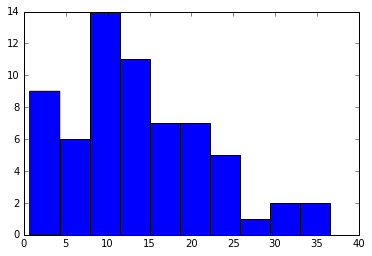

In [10]:
# histogram of HDN_01
ratios.sort()
pyplot.hist(ratios)

In [11]:
# high strain variation genomes based on HDN_01 ratio:
for k,v in hdn_csvs.items():
    r = v[0][1] / v[1][1]
    if r < 4.0:
        print('ratio={}, num={}, name={}'.format(r, k, names[k][:40]))
    

ratio=1.405891075319909, num=47, name=CP000753.1 Shewanella baltica OS185, com
ratio=1.2936867769518807, num=48, name=NC_010730.1 Sulfurihydrogenibium sp. YO3
ratio=0.6819785478213265, num=49, name=NZ_ABZS01000228.1 Sulfurihydrogenibium y
ratio=3.027725724126432, num=52, name=CP000702.1 Thermotoga petrophila RKU-1, 
ratio=3.236918521426877, num=53, name=CP000969.1 Thermotoga sp. RQ2, complete 
ratio=0.73476003348998, num=59, name=NZ_CH959311.1 Sulfitobacter sp. EE-36 sc
ratio=1.0053016175543028, num=60, name=NZ_CH959317.1 Sulfitobacter sp. NAS-14.1
ratio=1.2644029012497755, num=63, name=CP001252.1 Shewanella baltica OS223, com


In [12]:
# high similarity genomes based on minhash similarity
for k1 in sigs:
    for k2 in sigs:
        if k1 < k2 and sigs[k1].similarity(sigs[k2]) > 0.1:
            print("sim={}\n\t{}\n\t{}".format(sigs[k1].similarity(sigs[k2]), names[k1], names[k2]))

sim=0.38144329896907214
	CP000753.1 Shewanella baltica OS185, complete genome
	CP001252.1 Shewanella baltica OS223, complete genome
sim=0.19047619047619047
	NC_010730.1 Sulfurihydrogenibium sp. YO3AOP1, complete genome
	NZ_ABZS01000228.1 Sulfurihydrogenibium yellowstonense SS-5 gcontig_18, whole genome shotgun sequence
sim=0.45703125
	CP000702.1 Thermotoga petrophila RKU-1, complete genome
	CP000969.1 Thermotoga sp. RQ2, complete genome
sim=0.3800738007380074
	NZ_CH959311.1 Sulfitobacter sp. EE-36 scf_1099451318005, whole genome shotgun sequence
	NZ_CH959317.1 Sulfitobacter sp. NAS-14.1 scf_1099451320472, whole genome shotgun sequence


## conclusions

Well, this certainly seems like a suspiciously nice set of correlations - low HDN_01 measure (assembly free) also has high minhash similarity at genomic level (assembly based)